<a href="https://colab.research.google.com/github/Sandhya109hub/TechincalBlogWeb/blob/main/Recommender_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personalised Product Recommendation Engine
#### Social and information Networks Project
####

## Initialisation

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
%matplotlib inline

In [5]:
#Import data set
df = pd.read_excel("//content/Online Retail.xlsx")

In [6]:
print('dataset dimensions are:', df.shape)
df.describe(include = 'all')

dataset dimensions are: (541909, 8)


<ipython-input-6-1aa4d36225a5>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include = 'all')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


In [7]:
#Taking a smaller set of the data to speed up computations
df_sample = df.iloc[:4000]

## Data Pre-processing

In [8]:
#Delete rows with no Customer ID (if there is such a case)
cleaned_retail = df_sample.loc[pd.isnull(df_sample.CustomerID)==False]

#Create a lookup table
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

#Data cleaning' to raw data
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
print()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')


<ipython-input-8-a50eeca40dda>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
<ipython-input-8-a50eeca40dda>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1


In [9]:
#Count number of products and number of customers in the reduced dataset
no_products = len(grouped_purchased.StockCode.unique())
no_customers = len(grouped_purchased.CustomerID.unique())
print('Number of customers in dataset:', no_customers)
print('Number of products in dataset:', no_products)

Number of customers in dataset: 137
Number of products in dataset: 1131


## Create a Bipartite Graph

In [10]:
#Turn raw data to pivot ('ratings' matrix)
ratings = grouped_purchased.pivot(index = 'CustomerID', columns='StockCode', values='Quantity').fillna(0).astype('int')
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1

## Convert to a Weighted Product Graph

In [ ]:
#Initialize zeros dataframe for product interactions
products_integer = np.zeros((no_products,no_products))

#Count how many times each product pair has been purchased
print('Counting how many times each pair of products has been purchased...')
for i in range(no_products):
    for j in range(no_products):
        if i != j:
            df_ij = ratings_binary.iloc[:,[i,j]] #create a temporary df with only i and j products as columns
            sum_ij = df_ij.sum(axis=1)
            pairings_ij = len(sum_ij[sum_ij == 2]) #if s1_ij == 2 it means that both products were purchased by the same customer
            products_integer[i,j] = pairings_ij
            products_integer[j,i] = pairings_ij

Counting how many times each pair of products has been purchased...


In [ ]:
#Count how many customers have purchased each item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)

Counting how many times each individual product has been purchased...


In [ ]:
#Construct final weighted matrix of item interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((no_products,no_products))
for i in range(no_products):
    for j in range(no_products):
        if (times_purchased[i]+times_purchased[j]) !=0: #make sure you do not divide with zero
            products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])

Building weighted product matrix...


## Visualise Weighted Product matrix

In [ ]:
#Get list of item labels (instead of Codes)
nodes_codes = np.array(ratings_binary.columns).astype('str')
item_lookup_dict = pd.Series(item_lookup.Description.values,index=item_lookup.StockCode).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

In [ ]:
import networkx as nx
import numpy as np

# Assuming products_weighted is your NumPy matrix
G = nx.from_numpy_array(products_weighted)

# Now you can proceed with your graph operations.
pos = nx.random_layout(G)
labels = {}


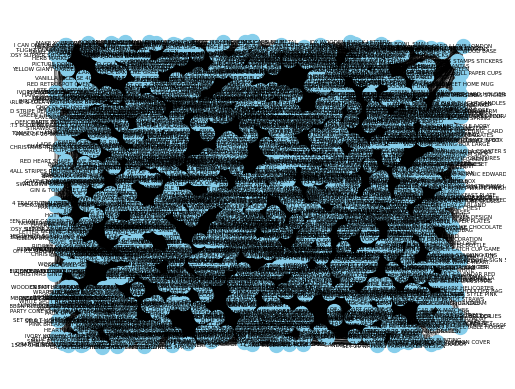

In [ ]:
for idx, node in enumerate(G.nodes()):
    labels[node] = nodes_labels[idx]

nx.draw_networkx_nodes(G, pos , node_color="skyblue", node_size=100)
nx.draw_networkx_edges(G, pos,  edge_color='k', width= 0.3, alpha= 0.5)
nx.draw_networkx_labels(G, pos, labels, font_size=4)
plt.axis('off')
plt.show()

#### For better visualisation, export the graph to Gephi

In [ ]:
#Export graph to Gephi
H=nx.relabel_nodes(G,labels) #create a new graph with Description labels and save to Gephi for visualizations
nx.write_gexf(H, "products.gexf")

## Louvain Clustering

In [ ]:
# function for setting colors of nodes and edges
def get_paired_color_palette(size):
    palette = []
    for i in range(size*2):
        palette.append(plt.cm.Paired(i))
    return palette

#Find communities of nodes (products)
louvain = community_louvain.best_partition(G, resolution = 1.5)
values = list(louvain.values())

communities =[]

for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    communities.append(nodelist)

## Visualise detected communities

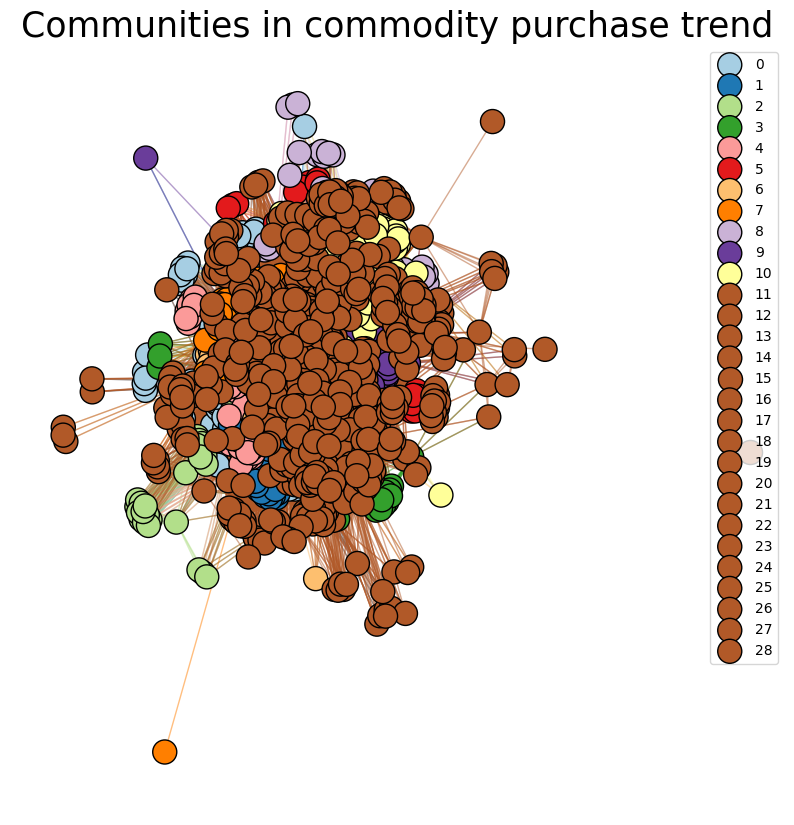

In [ ]:
#make plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize=(10, 10))
light_colors = get_paired_color_palette(clusters_count)
dark_colors = get_paired_color_palette(clusters_count)
g = nx.drawing.layout.spring_layout(G, weight = 'weight')

#iterate through each of the communities found by the Louvain algorithm and plot
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    edgelist = [e for e in G.edges if ((louvain[e[0]]==i) or (louvain[e[1]]==i))]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(G, g, nodelist=nodelist, node_color=node_color, edgecolors='k', label = i)
    nx.draw_networkx_edges(G, g, edgelist=edgelist, alpha=.5, edge_color=edge_color)

#set title, legend and show plot
plt.title('Communities in commodity purchase trend', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

## Performance Metrics

## Detected Community Analysis

In [ ]:
#Check how many communities were created
print('Number of communities:', len(np.unique(values)))

Number of communities: 29


In [ ]:
#Create dataframe with product description and community id
products_communities = pd.DataFrame(nodes_labels, columns = ['product_description'])
products_communities['community_id'] = values

In [ ]:
#Community 1
products_communities[products_communities['community_id']==1].head(40)

,product_description,community_id
1,MINI FUNKY DESIGN TAPES,1
47,BLUE ROSE FABRIC MIRROR,1
49,SET/9 CHRISTMAS T-LIGHTS SCENTED,1
102,SET/10 RED POLKADOT PARTY CANDLES,1
160,SKULLS WRITING SET,1
162,DINOSAURS WRITING SET,1
193,TOADSTOOL MONEY BOX,1
281,COSY SLIPPER SHOES SMALL RED,1
308,HEART T-LIGHT HOLDER,1
309,STAR T-LIGHT HOLDER,1


## Product Recommendation

In [ ]:
#Turn into dataframe
products_weighted_pd = pd.DataFrame(products_weighted, columns = nodes_labels)
products_weighted_pd.set_index(products_weighted_pd.columns, 'product', inplace=True)

products_prob = products_weighted_pd.divide(products_weighted_pd.max(axis = 1), axis = 0)

C:\Users\shazeb shaikh\AppData\Local\Temp\ipykernel_528\1643827117.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only.
  products_weighted_pd.set_index(products_weighted_pd.columns, 'product', inplace=True)


In [ ]:
#Saving the trained model for use in the UI
products_prob.to_csv('products_prob.csv')

---
## Testing



In [ ]:
#Add item to basket
basket = ['HOME BUILDING BLOCK WORD']
#Select the number of relevant items to suggest
no_of_suggestions = 3

all_of_basket = products_prob[basket]
all_of_basket = all_of_basket.sort_values(by = basket, ascending=False)
suggestions_to_customer = list(all_of_basket.index[:no_of_suggestions])

print('You may also consider buying:', suggestions_to_customer)

You may also consider buying: ['LOVE BUILDING BLOCK WORD', 'BATH BUILDING BLOCK WORD', 'ASSORTED COLOUR BIRD ORNAMENT']
